In [1]:
# Set this variable! If you're running in Google colab, set it to true.
is_colab = False

In [2]:
# Imports
if is_colab:
    from google.colab import drive
    from google.colab import drive
    drive.mount('/content/drive')
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
from scipy import stats
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Load the data
if is_colab:
    df = pd.read_csv('/content/drive/My Drive/WallStreetBetsClassifier/processed_larger.csv', names=["Time", "Ticker", "Body", "Author", "Score", "Ups", "Downs", "Controversiality", "Gilded", "Current_Price", "1D", "2D", "3D", "5D", "10D"])
else:
    df = pd.read_csv('processed_larger.csv', names=["Time", "Ticker", "Body", "Author", "Score", "Ups", "Downs", "Controversiality", "Gilded", "Current_Price", "1D", "2D", "3D", "5D", "10D"])

In [4]:
def price_change_trans(pct_change):
    if pct_change < -0.05: return 0
    elif pct_change < -0.01 and pct_change > -0.05: return 1
    elif pct_change < 0.01 and pct_change > -0.01: return 2
    elif pct_change < 0.05 and pct_change > 0.01: return 3
    else: return 4


# Add diffs in price columns, % changed and categorical price changes.
def add_price_cols(df):

    price_cols = ["1D", "2D", "3D", "5D", "10D"]

    for price in price_cols:
        percent_col = pd.DataFrame(df["Current_Price"] / df[price].fillna(0) - 1.00,  columns = [price + "_pct_change"])
        df = df.join(percent_col)

        # Categorical price change
        # "Down-, Down, Neutral, Up, Up+" = [<-5%, -1% - -5%, -1% - +1%, +1% - +5%, +5%+]
        price_change_df = pd.DataFrame(list(df[price + "_pct_change"].map(price_change_trans)), columns = [price + "_cat"])
        df = df.join(price_change_df)

    return df

df = add_price_cols(df)

In [5]:
# Make a train, val, test split for our data
def train_val_test_split(df, train_frac=0.8, val_frac=0.1):

    df.sort_values('Time')
    num_rows = len(df)
    train = df[0:int(train_frac * num_rows)]
    val = df[int(train_frac * num_rows):int(train_frac * num_rows)+int(val_frac * num_rows)]
    test = df[int(train_frac * num_rows)+int(val_frac * num_rows):]
    return train, val, test

train_df, val_df, test_df = train_val_test_split(df)

In [6]:
# Experiment class
class Experiment:
    def __init__(self, train_df, val_df, model, vectorizer, y_col_name="3D"):
        """
        vectorizer: accepts string and returns numpy array representing embedding for string
        Input: "I think SPY is going up"
        Output: np.array([343, 5674, 345, 3654, 23, 6546, 23434, 4345 234, 345]) 
        """
        self.train_df = train_df
        self.val_df = val_df
        self.model = model
        self.vectorizer = vectorizer
        self.X_train = None
        self.X_val = None
        self.y_train = None 
        self.y_val = None
        self.y_col_name = y_col_name
        
        self.populate_x_y()

    def vectorize_string(self, body):
        return self.vectorizer(body)

    def populate_x_y(self):
        # TODO: Our X could be more than just the body if we want to add more features, e.g. author, score
        # Turn into lists for use in sklearn.
        self.X_train = list(map(self.vectorizer, list(self.train_df["Body"])))
        self.X_val = list(map(self.vectorizer, list(self.val_df["Body"])))
        self.y_train = list(self.train_df[self.y_col_name])
        self.y_val = list(self.val_df[self.y_col_name])

    def fit(self, X=None, y=None):
        if X is None or y is None:
            X = self.X_train
            y = self.y_train
        self.model.fit(X, y)

    def predict(self, X_test=None):
        if X_test is None:
            X_test = self.X_val
        return self.model.predict(X_test)
    
    def get_metrics(self, y_pred=None, y_true=None):
        
        if y_pred is None:
            y_pred = self.predict()
        if y_true is None:
            y_true = self.y_val
        
        # TODO: Add some more metrics. (F1)
        accuracy = metrics.accuracy_score(y_pred, y_true)
        return accuracy


In [7]:
# Test the Experiment class
def dummy_vectorizer(body):
    return np.array([54, 54,34, 234 ,345, 345])

In [8]:
# This is from CS224U HW2
def glove2dict(src_filename):
    """GloVe Reader.

    Parameters
    ----------
    src_filename : str
        Full path to the GloVe file to be processed.

    Returns
    -------
    dict
        Mapping words to their GloVe vectors as `np.array`.

    """
    # This distribution has some words with spaces, so we have to
    # assume its dimensionality and parse out the lines specially:
    if '840B.300d' in src_filename:
        line_parser = lambda line: line.rsplit(" ", 300)
    else:
        line_parser = lambda line: line.strip().split()
    data = {}
    with open(src_filename, encoding='utf8') as f:
        while True:
            try:
                line = next(f)
                line = line_parser(line)
                data[line[0]] = np.array(line[1: ], dtype=np.float)
            except StopIteration:
                break
            except UnicodeDecodeError:
                pass
    return data

In [9]:
# Create a glove vectorizer from 300 dimensional Glove.6B
if is_colab:
    glove_dict = glove2dict("/content/drive/My Drive/WallStreetBetsClassifier/glove.6B.300d.txt")
else:
    glove_dict = glove2dict("glove.6B.300d.txt")

def glove_vectorizer(body):
  unk_vec = np.zeros(300)
  result = np.zeros(300)
  body_lower = body.lower()
  body_split = body_lower.split()
  for word in body_split:
    vec_for_word = glove_dict.get(word)
    if vec_for_word is None:
      vec_for_word = unk_vec
    result += vec_for_word
  return result

### **"Random" Guess**

In [10]:
y_col_name = "3D_cat"

# Use a normal distribution for our price changes.
np.random.seed(224)
norm = stats.norm(1.938, 1.223)

# Generate numbers according to this normal distribution.
y_pred_raw = norm.rvs(size = len(val_df))

y_pred = []
for val in y_pred_raw:
    if val < 0:
        y_pred.append(0)
    elif val > 4:
        y_pred.append(4)
    else:
        y_pred.append(int(round(val)))

# Create an experiment to do a random guess according to a normal distributions.
experiment_random = Experiment(train_df, val_df, None, lambda x: x, y_col_name=y_col_name)
y_true = experiment_random.y_val

print(metrics.accuracy_score(y_pred, y_true))


0.22815407355882097


### **Linear SVM**

In [11]:
from sklearn.svm import LinearSVC

# Train a model using the 3-day price change category as the predicted value.
experiment_svm = Experiment(train_df, val_df, LinearSVC(random_state=0, tol=1e-5, verbose=1, max_iter=1000), glove_vectorizer, y_col_name=y_col_name)
experiment_svm.fit()
experiment_svm.get_metrics()

[LibLinear]

C:\Users\anthony\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.14381358142770193

### **Random Forest**

In [12]:
# Get distribution of class weights of training data.
class_weights = train_df[y_col_name].value_counts().to_dict()

experiment_rf = Experiment(train_df, val_df, RandomForestClassifier(n_estimators = 100, n_jobs=-1, class_weight = class_weights, verbose=1), glove_vectorizer, y_col_name=y_col_name)

experiment_rf.fit()
experiment_rf.get_metrics()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


0.2787583688374924

### MLP Classifier (non-GPU Multi-layer Perceptron)

In [13]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(activation='relu', solver='adam', max_iter=500, verbose=True)
experiment_mlp = Experiment(train_df, val_df, mlp, glove_vectorizer, y_col_name=y_col_name)
experiment_mlp.fit()
experiment_mlp.get_metrics()

Iteration 1, loss = 1.87587151
Iteration 2, loss = 1.64428090
Iteration 3, loss = 1.60641562
Iteration 4, loss = 1.57655621
Iteration 5, loss = 1.55636955
Iteration 6, loss = 1.53479459
Iteration 7, loss = 1.53463552
Iteration 8, loss = 1.51939784
Iteration 9, loss = 1.51363144
Iteration 10, loss = 1.50008783
Iteration 11, loss = 1.49923838
Iteration 12, loss = 1.48529061
Iteration 13, loss = 1.47747173
Iteration 14, loss = 1.47267526
Iteration 15, loss = 1.46614073
Iteration 16, loss = 1.46285658
Iteration 17, loss = 1.45608438
Iteration 18, loss = 1.45170201
Iteration 19, loss = 1.45062426
Iteration 20, loss = 1.44811444
Iteration 21, loss = 1.44433758
Iteration 22, loss = 1.43881807
Iteration 23, loss = 1.43588942
Iteration 24, loss = 1.43115340
Iteration 25, loss = 1.42660455
Iteration 26, loss = 1.42366940
Iteration 27, loss = 1.42194673
Iteration 28, loss = 1.42283012
Iteration 29, loss = 1.41474092
Iteration 30, loss = 1.41028970
Iteration 31, loss = 1.40686720
Iteration 32, los

Iteration 253, loss = 1.22090194
Iteration 254, loss = 1.22097812
Iteration 255, loss = 1.22346034
Iteration 256, loss = 1.21897671
Iteration 257, loss = 1.21925327
Iteration 258, loss = 1.22043205
Iteration 259, loss = 1.21868496
Iteration 260, loss = 1.21781023
Iteration 261, loss = 1.21970039
Iteration 262, loss = 1.21729991
Iteration 263, loss = 1.21747387
Iteration 264, loss = 1.21827403
Iteration 265, loss = 1.21710210
Iteration 266, loss = 1.21694687
Iteration 267, loss = 1.21514507
Iteration 268, loss = 1.22759805
Iteration 269, loss = 1.22000239
Iteration 270, loss = 1.21494876
Iteration 271, loss = 1.21603542
Iteration 272, loss = 1.21319518
Iteration 273, loss = 1.21851002
Iteration 274, loss = 1.21509107
Iteration 275, loss = 1.21400268
Iteration 276, loss = 1.21456361
Iteration 277, loss = 1.21435373
Iteration 278, loss = 1.21336915
Iteration 279, loss = 1.21313315
Iteration 280, loss = 1.21328006
Iteration 281, loss = 1.21461312
Iteration 282, loss = 1.21415604
Iteration 

0.26867228936614207

### Visualization

{1: 25524, 2: 23295, 3: 20305, 4: 11589, 0: 11299}
0.2773986001825849


C:\Users\anthony\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\anthony\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


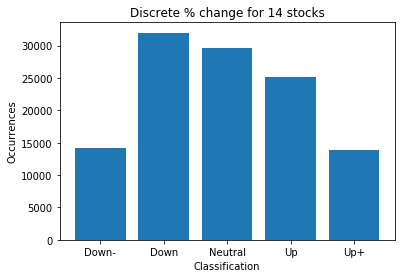

In [15]:
import matplotlib.pyplot as plt

# Distribution of the training data according to categorical price changes.
class_weights = train_df[y_col_name].value_counts().to_dict()
print(class_weights)
print(class_weights[1] / sum(class_weights.values()))



# Get occurrences, but we want whole number percents. Multiply by 100
occurrences = list(df['3D_pct_change'].apply(lambda x: x*100))

n, bins, patches = plt.hist(occurrences, 1000)
plt.xlim(-10, 10)
plt.xlabel("Percent change over 3 days")
plt.ylabel("Occurrences")
plt.title("Continuous % change for 14 stocks")
#plt.show()
plt.savefig("continuous.png")

plt.clf()

# Graph for discrete price change categories
occurrences_dict = {"Down-" : (df.loc[df['3D_pct_change'] < -0.05]).shape[0], 
            "Down" : (df.loc[(df['3D_pct_change'] >= -0.05) & (df['3D_pct_change'] <= -0.01)]).shape[0],
            "Neutral" : (df.loc[(df['3D_pct_change'] >= -0.01) & (df['3D_pct_change'] <= 0.01)]).shape[0],
            "Up" : (df.loc[(df['3D_pct_change'] >= 0.01) & (df['3D_pct_change'] <= 0.05)]).shape[0],
            "Up+" : (df.loc[df['3D_pct_change'] >= 0.05]).shape[0]}

plt.bar(occurrences_dict.keys(), occurrences_dict.values())
plt.xlabel("Classification")
plt.ylabel("Occurrences")
plt.title("Discrete % change for 14 stocks")
#plt.show()
plt.savefig("discrete.png")